In [1]:
import sys
sys.path.append('./../../')

import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
import argparse
from config_reader import ConfigReader
from modules.dvae.model import DVAE
from modules.vqvae.model import VQVAE
from datasets.mnist_loader import MNISTData
from datasets.cub_loader import CUBData

from modules.common_utils import latent_to_img
from notebooks.utils import show

In [2]:
config_folder_path = '/u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/finished/'

config_path_vqvae_vs = config_folder_path + 'comparison_vqvae_cub128_v512_ds2_vocabsep.yaml'
CONFIG_vqvae_vs = ConfigReader(config_path=config_path_vqvae_vs)

config_path_vqvae_jo = config_folder_path + 'comparison_vqvae_cub128_v512_ds2_jointopt.yaml'
CONFIG_vqvae_jo = ConfigReader(config_path=config_path_vqvae_jo)

config_path_dvae = config_folder_path + 'comparison_dvae_cub128_v512_ds2.yaml'
CONFIG_dvae = ConfigReader(config_path=config_path_dvae)

config_path_dvae_fkl = config_folder_path + 'comparison_dvae_cub128_v512_ds2_fixed_kl.yaml'
CONFIG_dvae_fkl = ConfigReader(config_path=config_path_dvae_fkl)

config_path_dvae_64 = config_folder_path + 'dvae_cub64_v512_ds2.yaml'
CONFIG_dvae_64 = ConfigReader(config_path=config_path_dvae_64)

In [3]:
vqvae_vs = VQVAE(
    img_channels=CONFIG_vqvae_vs.in_channels,
    num_embeddings=CONFIG_vqvae_vs.vocab_size,
    embedding_dim=CONFIG_vqvae_vs.vqvae_embedding_dim,
    commitment_cost=CONFIG_vqvae_vs.vqvae_commitment_cost,
    decay=CONFIG_vqvae_vs.vqvae_decay,
    num_x2downsamples=CONFIG_vqvae_vs.num_x2downsamples,
    num_resid_downsample_layers=CONFIG_vqvae_vs.num_resids_downsample,
    num_resid_bottleneck_layers=CONFIG_vqvae_vs.num_resids_bottleneck,
    use_batch_norm=True,
    use_conv1x1=True)

vqvae_vs.eval()
vqvae_vs.load_model(
    root_path=CONFIG_vqvae_jo.save_model_path,
    model_name=CONFIG_vqvae_jo.save_model_name)

In [4]:
vqvae_jo = VQVAE(
    img_channels=CONFIG_vqvae_jo.in_channels,
    num_embeddings=CONFIG_vqvae_jo.vocab_size,
    embedding_dim=CONFIG_vqvae_jo.vqvae_embedding_dim,
    commitment_cost=CONFIG_vqvae_jo.vqvae_commitment_cost,
    decay=CONFIG_vqvae_jo.vqvae_decay,
    num_x2downsamples=CONFIG_vqvae_jo.num_x2downsamples,
    num_resid_downsample_layers=CONFIG_vqvae_jo.num_resids_downsample,
    num_resid_bottleneck_layers=CONFIG_vqvae_jo.num_resids_bottleneck,
    use_batch_norm=True,
    use_conv1x1=True)

vqvae_jo.eval()
vqvae_jo.load_model(
    root_path=CONFIG_vqvae_jo.save_model_path,
    model_name=CONFIG_vqvae_jo.save_model_name)

In [5]:
dvae = DVAE(
    in_channels=CONFIG_dvae.in_channels,
    vocab_size=CONFIG_dvae.vocab_size,
    num_x2downsamples=CONFIG_dvae.num_x2downsamples,
    num_resids_downsample=CONFIG_dvae.num_resids_downsample,
    num_resids_bottleneck=CONFIG_dvae.num_resids_bottleneck,
    hidden_dim=CONFIG_dvae.hidden_dim)

dvae.eval()
dvae.load_model(
    root_path=CONFIG_dvae.save_model_path,
    model_name=CONFIG_dvae.save_model_name)

In [6]:
dvae_fkl = DVAE(
    in_channels=CONFIG_dvae_fkl.in_channels,
    vocab_size=CONFIG_dvae_fkl.vocab_size,
    num_x2downsamples=CONFIG_dvae_fkl.num_x2downsamples,
    num_resids_downsample=CONFIG_dvae_fkl.num_resids_downsample,
    num_resids_bottleneck=CONFIG_dvae_fkl.num_resids_bottleneck,
    hidden_dim=CONFIG_dvae_fkl.hidden_dim)

dvae_fkl.eval()
dvae_fkl.load_model(
    root_path=CONFIG_dvae_fkl.save_model_path,
    model_name=CONFIG_dvae_fkl.save_model_name)

In [7]:
dvae_64 = DVAE(
    in_channels=CONFIG_dvae_64.in_channels,
    vocab_size=CONFIG_dvae_64.vocab_size,
    num_x2downsamples=CONFIG_dvae_64.num_x2downsamples,
    num_resids_downsample=CONFIG_dvae_64.num_resids_downsample,
    num_resids_bottleneck=CONFIG_dvae_64.num_resids_bottleneck,
    hidden_dim=CONFIG_dvae_64.hidden_dim)

dvae_64.eval()
dvae_64.load_model(
    root_path=CONFIG_dvae_64.save_model_path,
    model_name=CONFIG_dvae_64.save_model_name)

In [8]:
data_source = CUBData(
    img_type=CONFIG_vqvae_vs.dataset_type,
    root_path=CONFIG_vqvae_vs.root_path,
    batch_size=CONFIG_vqvae_vs.BATCH_SIZE,
    prct_train_split=0.99,
    custom_transform_version=CONFIG_vqvae_vs.custom_transform_version)

# loader = data_source.get_train_loader()
# img, _ = next(iter(train_loader))

In [9]:
img = data_source.get_imgs_by_file_names([
    '042.Vermilion_Flycatcher/Vermilion_Flycatcher_0005_42478.jpg',
    '035.Purple_Finch/Purple_Finch_0008_27455.jpg',
    '076.Dark_eyed_Junco/Dark_Eyed_Junco_0011_66280.jpg',
    '067.Anna_Hummingbird/Anna_Hummingbird_0017_56954.jpg',
    '170.Mourning_Warbler/Mourning_Warbler_0033_166489.jpg',
    '187.American_Three_toed_Woodpecker/American_Three_Toed_Woodpecker_0029_796143.jpg',
])

# dvae favour
# '170.Mourning_Warbler/Mourning_Warbler_0033_166489.jpg'
# '076.Dark_eyed_Junco/Dark_Eyed_Junco_0011_66280.jpg'
# '187.American_Three_toed_Woodpecker/American_Three_Toed_Woodpecker_0029_796143.jpg'
# '067.Anna_Hummingbird/Anna_Hummingbird_0017_56954.jpg'

# vqvae favour
# '035.Purple_Finch/Purple_Finch_0008_27455.jpg'
# '042.Vermilion_Flycatcher/Vermilion_Flycatcher_0005_42478.jpg'

In [10]:
# show(img)

# print('VQ-VAE vocab. sep.')
# show(vqvae_vs.get_reconstruction(img))

# print('VQ-VAE joint')
# show(vqvae_jo.get_reconstruction(img))

# print('dVAE')
# show(dvae.get_reconstruction(img))

# print('dVAE fixed KL')
# show(dvae_fkl.get_reconstruction(img))

# print('dVAE 64')
# show(dvae_64.get_reconstruction(img))

In [11]:
img_1 = vqvae_vs.get_reconstruction(img)
img_2 = vqvae_jo.get_reconstruction(img)
img_3 = dvae.get_reconstruction(img)
img_4 = dvae_fkl.get_reconstruction(img)
img_5 = dvae_64.get_reconstruction(img)

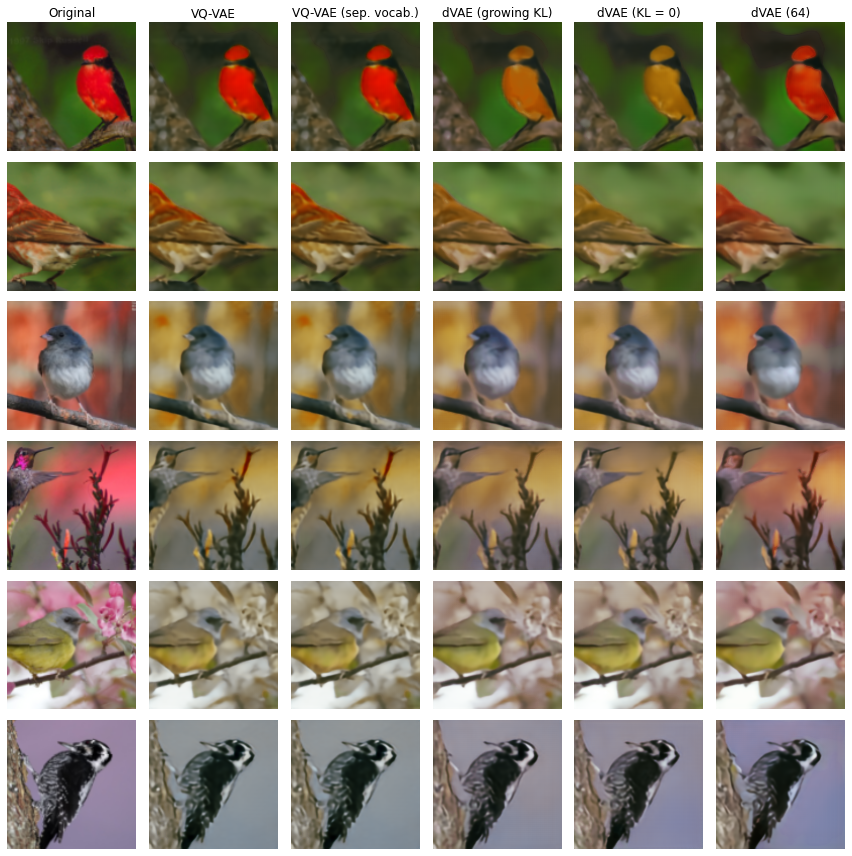

In [12]:
img_stack = torch.cat([img, img_1, img_2, img_3, img_4, img_5], dim=0)
titles = [
    'Original',
    'VQ-VAE',
    'VQ-VAE (sep. vocab.)',
    'dVAE (growing KL)',
    'dVAE (KL = 0)',
    'dVAE (64)'
]

plt.figure(figsize=(12,12))

num = 1
for i in range(6):
    for j in range(6):
        plt.subplot(6, 6, num)
        if num <= 6: plt.title(titles[num-1])
        plt.imshow(img_stack[i + j * 6].permute(1,2,0).detach().numpy())
        plt.axis('off')
        num += 1

plt.tight_layout()
plt.show()